<a href="https://colab.research.google.com/github/dkayikci/ML-Arch/blob/main/2024initial_ClassicalMLHittite1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL')

Mounted at /content/drive


In [ ]:
#import the necessary libraries:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def print_directory_structure(path, level=0):
    print('    ' * level + os.path.basename(path) + '/')
    if level < 2:  # Limit depth to avoid excessive output
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print_directory_structure(item_path, level + 1)
            else:
                print('    ' * (level + 1) + item)

folder_path = "/content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL"
print("Directory structure:")
print_directory_structure(folder_path)

Directory structure:
FSL/
    queryL2_24/
        sakca/
        aslan/
        karka/
        alaca/
    supportL2_112/
        sakca/
        alaca/
        karka/
        aslan/


In [ ]:
#define the function to load and preprocess images:
def load_images(folder_path):
    images = []
    labels = []
    for subset in ['queryL2_24', 'supportL2_112']:
        subset_path = os.path.join(folder_path, subset)
        for class_folder in os.listdir(subset_path):
            class_path = os.path.join(subset_path, class_folder)
            if os.path.isdir(class_path):
                for image_file in os.listdir(class_path):
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(class_path, image_file)
                        try:
                            image = cv2.imread(image_path)
                            if image is None:
                                print(f"Failed to load image: {image_path}")
                                continue
                            image = cv2.resize(image, (100, 100))  # Resize for consistency
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                            images.append(image.flatten())  # Flatten the image into a 1D array
                            labels.append(class_folder)
                            print(f"Successfully loaded: {image_path}")
                        except Exception as e:
                            print(f"Error processing {image_path}: {str(e)}")

    if not images:
        raise ValueError("No images were successfully loaded. Please check the file path and image formats.")

    return np.array(images), np.array(labels)

# Load images
folder_path = "/content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL"
try:
    X, y = load_images(folder_path)
    print(f"Successfully loaded {len(X)} images.")
    print(f"Unique labels: {np.unique(y)}")
    print(f"Number of images per class:")
    for label in np.unique(y):
        print(f"{label}: {np.sum(y == label)}")
except Exception as e:
    print(f"Error loading images: {str(e)}")

Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/77F4Sakcagozu-f.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/81F2Sakcagozu-f.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/81F2Sakcagozu-a.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/81F2Sakcagozu-d.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/77F4Sakcagozu-d.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/sakca/80F2Sakcagozu-d.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/aslan/56F2Aslantepe-d.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/stelea1500x1000pxsL2/FSL/queryL2_24/aslan/57F2Aslantepe-c.jpg
Successfully loaded: /content/drive/MyDrive/MetaHittite/

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, f1, cv_scores, cm

def print_confusion_matrix(cm, classes):
    print("Confusion Matrix:")
    print("    " + " ".join(f"{c:>5}" for c in classes))
    for i, row in enumerate(cm):
        print(f"{classes[i]:>3} " + " ".join(f"{cell:>5}" for cell in row))
    print()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVM Results:
Accuracy: 0.3929
Precision: 0.4008
F1 Score: 0.3910
Cross-validation Scores: [0.36363636 0.36363636 0.22727273 0.38095238 0.38095238]
Average CV Score: 0.3433
Confusion Matrix:
    alaca aslan karka sakca
alaca     2     2     3     1
aslan     0     3     0     3
karka     2     1     1     0
sakca     2     3     0     5



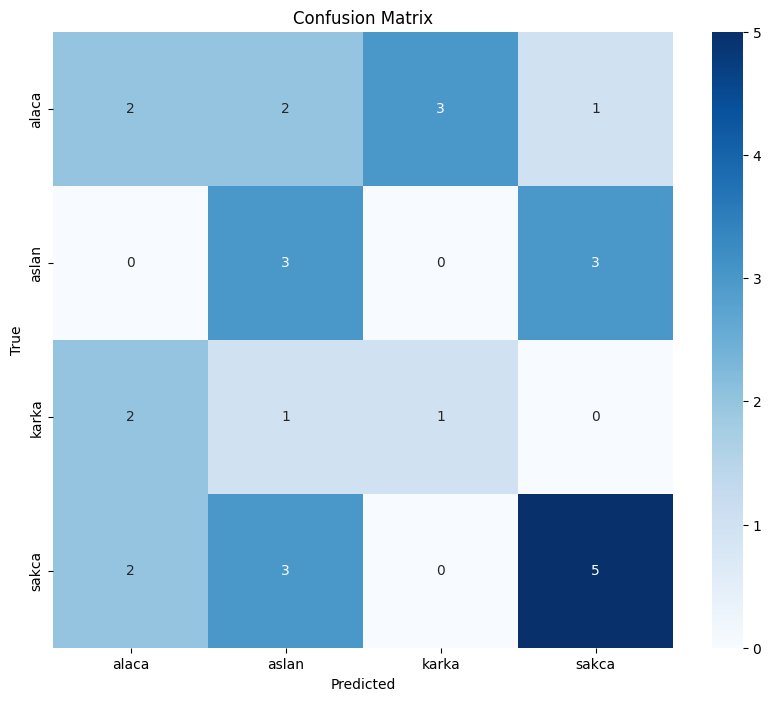

KNN Results:
Accuracy: 0.2500
Precision: 0.5094
F1 Score: 0.2341
Cross-validation Scores: [0.31818182 0.31818182 0.31818182 0.19047619 0.42857143]
Average CV Score: 0.3147
Confusion Matrix:
    alaca aslan karka sakca
alaca     1     3     4     0
aslan     0     4     0     2
karka     0     4     0     0
sakca     0     8     0     2



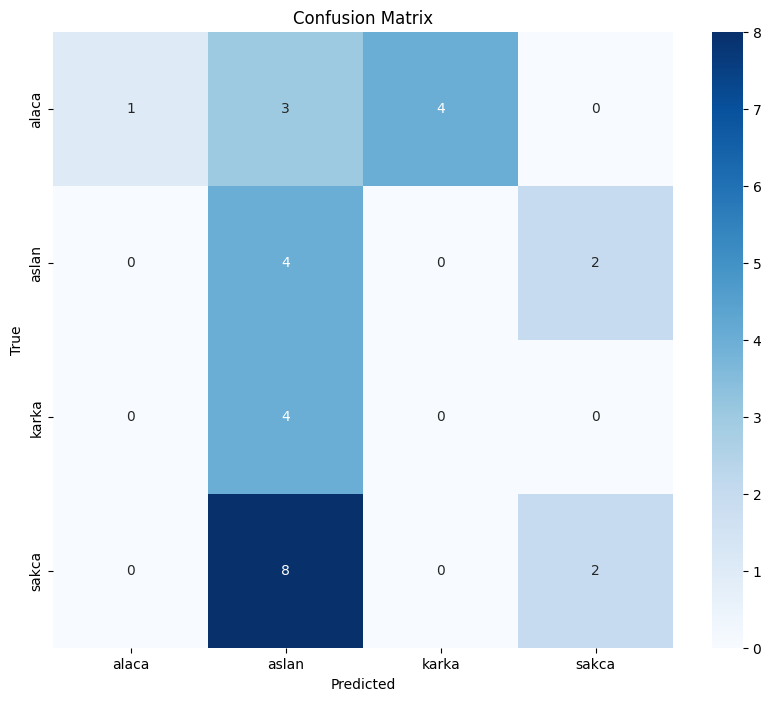

Random Forest Results:
Accuracy: 0.4286
Precision: 0.4484
F1 Score: 0.4277
Cross-validation Scores: [0.27272727 0.40909091 0.22727273 0.33333333 0.33333333]
Average CV Score: 0.3152
Confusion Matrix:
    alaca aslan karka sakca
alaca     2     4     1     1
aslan     0     3     0     3
karka     1     1     2     0
sakca     2     2     1     5



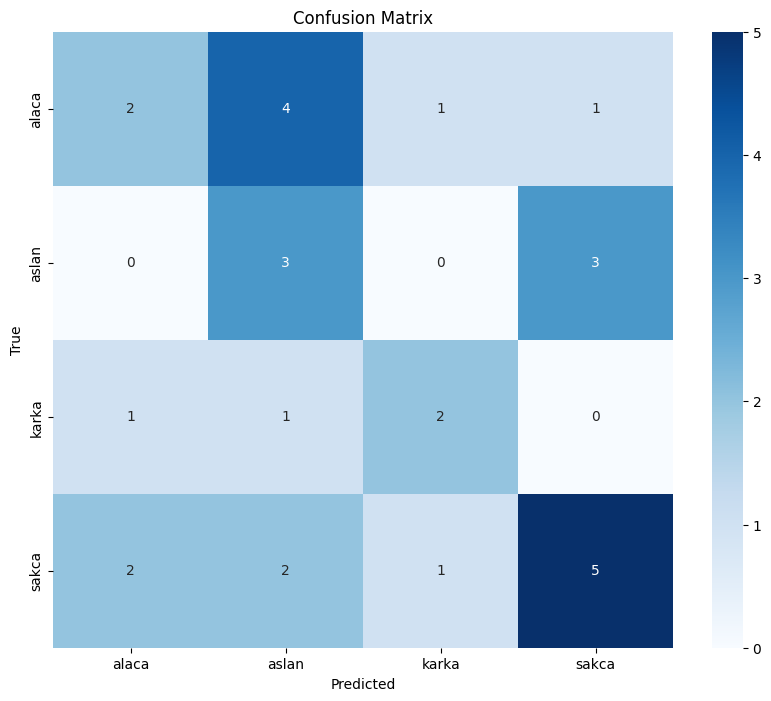

Logistic Regression Results:
Accuracy: 0.5000
Precision: 0.5893
F1 Score: 0.5119
Cross-validation Scores: [0.40909091 0.5        0.40909091 0.42857143 0.23809524]
Average CV Score: 0.3970
Confusion Matrix:
    alaca aslan karka sakca
alaca     3     2     2     1
aslan     0     4     1     1
karka     0     3     1     0
sakca     1     3     0     6



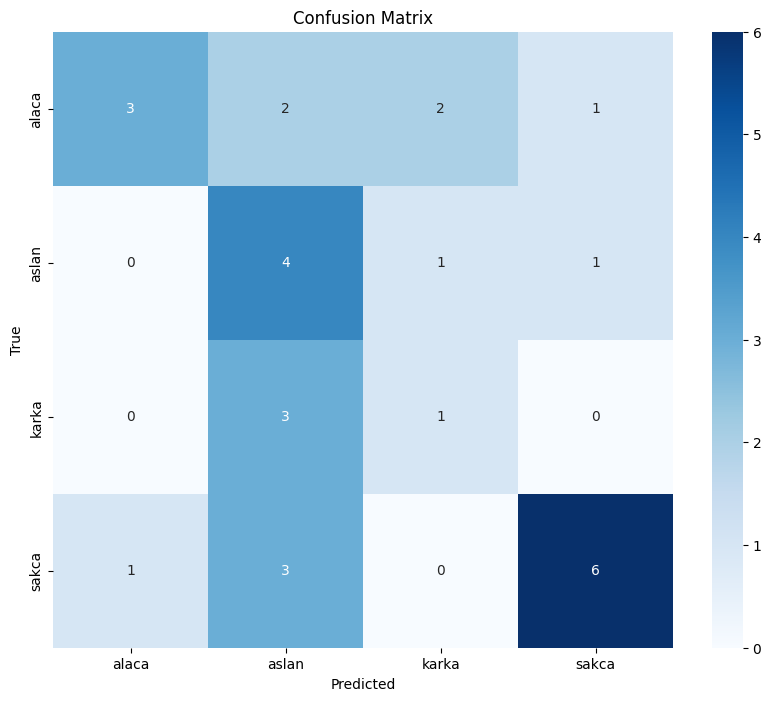

Decision Tree Results:
Accuracy: 0.2500
Precision: 0.2989
F1 Score: 0.2655
Cross-validation Scores: [0.31818182 0.40909091 0.36363636 0.23809524 0.33333333]
Average CV Score: 0.3325
Confusion Matrix:
    alaca aslan karka sakca
alaca     1     3     3     1
aslan     1     1     2     2
karka     2     1     1     0
sakca     2     3     1     4



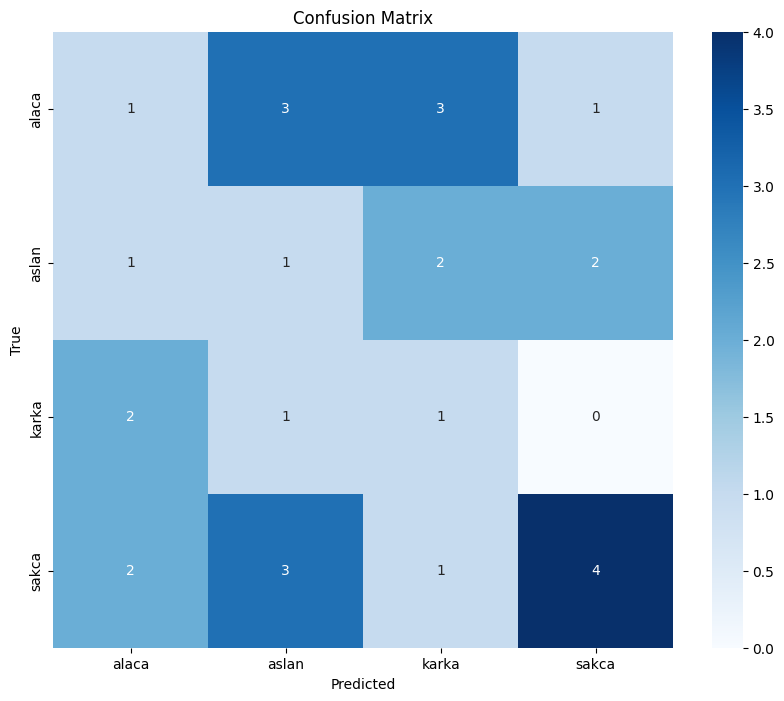

Naive Bayes Results:
Accuracy: 0.3571
Precision: 0.3662
F1 Score: 0.3449
Cross-validation Scores: [0.36363636 0.31818182 0.31818182 0.42857143 0.33333333]
Average CV Score: 0.3524
Confusion Matrix:
    alaca aslan karka sakca
alaca     1     4     2     1
aslan     0     2     0     4
karka     1     2     1     0
sakca     1     1     2     6



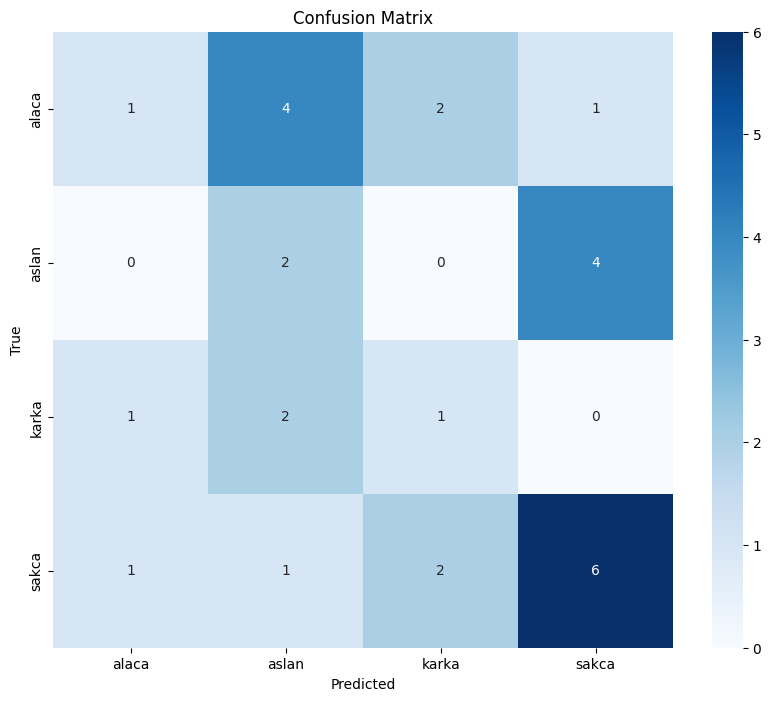

In [ ]:
#train and evaluate each model:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_accuracy, svm_precision, svm_f1, svm_cv_scores, svm_cm = train_and_evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("SVM Results:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"F1 Score: {svm_f1:.4f}")
print(f"Cross-validation Scores: {svm_cv_scores}")
print(f"Average CV Score: {np.mean(svm_cv_scores):.4f}")
print_confusion_matrix(svm_cm, np.unique(y))
plot_confusion_matrix(svm_cm, np.unique(y))

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy, knn_precision, knn_f1, knn_cv_scores, knn_cm = train_and_evaluate_model(knn_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("KNN Results:")
print(f"Accuracy: {knn_accuracy:.4f}")
print(f"Precision: {knn_precision:.4f}")
print(f"F1 Score: {knn_f1:.4f}")
print(f"Cross-validation Scores: {knn_cv_scores}")
print(f"Average CV Score: {np.mean(knn_cv_scores):.4f}")
print_confusion_matrix(knn_cm, np.unique(y))
plot_confusion_matrix(knn_cm, np.unique(y))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accuracy, rf_precision, rf_f1, rf_cv_scores, rf_cm = train_and_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"Cross-validation Scores: {rf_cv_scores}")
print(f"Average CV Score: {np.mean(rf_cv_scores):.4f}")
print_confusion_matrix(rf_cm, np.unique(y))
plot_confusion_matrix(rf_cm, np.unique(y))

# Logistic Regression
lr_model = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000)
lr_accuracy, lr_precision, lr_f1, lr_cv_scores, lr_cm = train_and_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"Cross-validation Scores: {lr_cv_scores}")
print(f"Average CV Score: {np.mean(lr_cv_scores):.4f}")
print_confusion_matrix(lr_cm, np.unique(y))
plot_confusion_matrix(lr_cm, np.unique(y))

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_accuracy, dt_precision, dt_f1, dt_cv_scores, dt_cm = train_and_evaluate_model(dt_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Decision Tree Results:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"F1 Score: {dt_f1:.4f}")
print(f"Cross-validation Scores: {dt_cv_scores}")
print(f"Average CV Score: {np.mean(dt_cv_scores):.4f}")
print_confusion_matrix(dt_cm, np.unique(y))
plot_confusion_matrix(dt_cm, np.unique(y))

# Naive Bayes
nb_model = GaussianNB()
nb_accuracy, nb_precision, nb_f1, nb_cv_scores, nb_cm = train_and_evaluate_model(nb_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Naive Bayes Results:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"F1 Score: {nb_f1:.4f}")
print(f"Cross-validation Scores: {nb_cv_scores}")
print(f"Average CV Score: {np.mean(nb_cv_scores):.4f}")
print_confusion_matrix(nb_cm, np.unique(y))
plot_confusion_matrix(nb_cm, np.unique(y))